In [2]:
import os
#os.chdir("//share/data/AFTLab/SC/")

from google.colab import drive
drive.mount('/content/drive')
#os.chdir("drive/MyDrive/DehanCui/data")

root_dir = "/content/drive/My Drive/"
project_folder = "Asset pricing x supply chain project/Main_Code"
os.chdir(root_dir + project_folder)

import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, TransformerConv
from torch.optim import Adam
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
import pickle as pkl

# Plot heatmap of Sharpe ratios

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

# Functions

In [3]:
def RPPCAOOS(Xtotal, stdnorm, gamma, K, window):
  """
    Out-of-sample evaluation of RP-PCA (Risk-Premium Principal Component Analysis).

    Parameters:
    -----------
    Xtotal : numpy.ndarray
        A (Ttotal x N) matrix of excess returns where Ttotal is the total number of time periods
        and N is the number of assets.
    stdnorm : int
        Normalization by standard deviation. Use stdnorm=0 as standard (no normalization).
        If stdnorm=1, the matrix is normalized by the standard deviation.
    gamma : float
        Risk premium parameter that controls the impact of the risk premium in the weighting matrix.
    K : int
        Number of factors to be extracted in the RP-PCA.
    window : int
        Length of the rolling window for out-of-sample estimation. Typically, use window=240.

    Returns:
    --------
    output : dict
        A dictionary containing the following keys:
        - "OOS_results": numpy.ndarray
            Out-of-sample results including SR (Sharpe Ratio), RMS-alpha, and unexplained variation
            for different numbers of factors.
        - "IS_results": numpy.ndarray
            In-sample results including SR, RMS-alpha, and unexplained variation for different
            numbers of factors.
        - "Corrfinal": numpy.ndarray
            Generalized correlation between loadings estimated on a rolling window and the whole sample.
        - "Lambdahattimerotated": numpy.ndarray
            Locally estimated loadings rotated to align with the loadings estimated on the full sample.
    """
  # Out-of-sample evaluation of RP-PCA

  N = Xtotal.shape[1]
  Ttotal = Xtotal.shape[0]

  Tstart = window + 1
  Tfinal = Ttotal  # Define Tfinal here as the total number of time periods
  TOOS = Ttotal - window

  # In-sample analysis
  X = Xtotal.copy()
  T = Ttotal

  if stdnorm == 1:
      WN = np.linalg.inv(np.sqrt(np.diag(np.diag(X.T @ (np.eye(T) - np.ones((T, T)) / T) @ X / T / N))))
  else:
      WN = np.eye(N)

  WT = np.eye(T) + gamma * np.ones((T, T)) / T

  # Generic estimator for general weighting matrices
  Xtilde = X @ WN

  # Covariance matrix with weighted mean
  VarWPCA = Xtilde.T @ WT @ Xtilde / (N * T)

  # Eigenvalue decomposition
  DWPCA, VWPCA = np.linalg.eig(VarWPCA)
  ID = np.argsort(DWPCA)[::-1]
  DDWPCA = DWPCA[ID]
  VWPCA = VWPCA[:, ID]

  # Loadings after reverting the cross-sectional transformation
  Lambdahat = np.linalg.inv(WN.T) @ VWPCA[:, :K]

  # Normalizing the signs of the loadings
  Lambdahat = Lambdahat @ np.diag(np.sign(np.mean(X @ Lambdahat @ np.linalg.inv(Lambdahat.T @ Lambdahat), axis=0)))
  Lambdahattotal = Lambdahat.copy()

  # Constructing the latent factors
  Fhat = X @ Lambdahat @ np.linalg.inv(Lambdahat.T @ Lambdahat)
  Fhat_total = Fhat.copy()

  # Initialize variables for in-sample analysis
  SDF = np.zeros((T, K))
  SR = np.zeros(K)
  a = np.zeros((N, K))
  beta = [None] * K
  residual = [None] * K
  VaralphaIS = np.zeros(K)
  VaralphapercentIS = np.zeros(K)
  RMSEalphaIS = np.zeros(K)

  for k in range(K):
      factors = Fhat[:, :k+1]

      # If factors has only one column, treat it as 2D
      if factors.shape[1] == 1:
          cov_matrix = np.var(factors, ddof=1)  # This gives a scalar (variance)
          SDFweights = 1 / cov_matrix * np.mean(factors, axis=0)  # Scalar division
      else:
          cov_matrix = np.cov(factors.T)
          SDFweights = np.linalg.inv(cov_matrix) @ np.mean(factors, axis=0)

      SDF[:, k] = factors @ SDFweights
      SR[k] = np.mean(SDF[:, k]) / np.std(SDF[:, k])

      # Time-series regressions
      reg_matrix = np.column_stack((np.ones(T), factors))
      dummy = np.linalg.inv(reg_matrix.T @ reg_matrix) @ reg_matrix.T @ X
      residual[k] = X - reg_matrix @ dummy
      a[:, k] = dummy[0, :]
      beta[k] = dummy[1:k+2, :].T
      VaralphaIS[k] = np.trace(np.cov(residual[k].T)) / N
      VaralphapercentIS[k] = np.trace(np.cov(residual[k].T)) / np.trace(np.cov(Xtotal)) * 100
      RMSEalphaIS[k] = np.sqrt((a[:, k].T @ a[:, k]) / N)

  # Out-of-sample Analysis
  Corrfinal = np.zeros((TOOS, K))
  Lambdahattimerotated = np.zeros((N, K, TOOS))
  OptimalPortfolioWeightstime = [None] * TOOS
  Sigmatime = [None] * TOOS
  mutime = [None] * TOOS
  maxreturntime = np.zeros((TOOS, K))

  for t in range(TOOS):
      X = Xtotal[t:Tstart+t-1, :]
      T = X.shape[0]
      Xnext = Xtotal[Tstart+t-1, :]

      if stdnorm == 1:
          WN = np.linalg.inv(np.sqrt(np.diag(np.diag(X.T @ (np.eye(T) - np.ones((T, T)) / T) @ X / T / N))))
      else:
          WN = np.eye(N)

      WT = np.eye(T) + gamma * np.ones((T, T)) / T

      # Generic estimator for general weighting matrices
      Xtilde = X @ WN

      # Covariance matrix with weighted mean
      VarWPCA = Xtilde.T @ WT @ Xtilde / (N * T)

      # Eigenvalue decomposition
      DWPCA, VWPCA = np.linalg.eig(VarWPCA)
      ID = np.argsort(DWPCA)[::-1]
      DDWPCA = DWPCA[ID]
      VWPCA = VWPCA[:, ID]

      # Loadings after reverting the cross-sectional transformation
      Lambdahat = np.linalg.inv(WN.T) @ VWPCA[:, :K]

      # Normalizing the signs of the loadings
      if t == 0:
          Lambdahat = Lambdahat @ np.diag(np.sign(np.mean(X @ Lambdahat @ np.linalg.inv(Lambdahat.T @ Lambdahat), axis=0)))
      else:
          Lambdahat = Lambdahat @ np.diag(np.sign(np.diag(Lambdahat.T @ Lambdahatprevious)))

      Lambdahatprevious = Lambdahat.copy()

      Fhat = X @ Lambdahat[:, :K] @ np.linalg.inv(Lambdahat[:, :K].T @ Lambdahat[:, :K])

      # Generalized correlation with constant loadings:
      corr_matrix = np.linalg.inv(Lambdahat.T @ Lambdahat) @ Lambdahat.T @ Lambdahattotal @ np.linalg.inv(Lambdahattotal.T @ Lambdahattotal) @ Lambdahattotal.T @ Lambdahat
      Corrfinal[t, :] = np.sort(np.sqrt(np.abs(np.linalg.eigvals(corr_matrix))), axis=0)[::-1]

      # Time-varying loadings rotated
      Lambdahattimerotated[:, :, t] = Lambdahat @ np.linalg.inv(Lambdahat.T @ Lambdahat) @ Lambdahat.T @ Lambdahattotal

      for k in range(K):
          # OLS regression with intercept
          reg_matrix = np.column_stack((np.ones(T), Fhat[:, :k+1]))
          dummytime = np.linalg.inv(reg_matrix.T @ reg_matrix) @ reg_matrix.T @ X
          betatime = dummytime[1:, :].T

          alpha = Xnext @ (np.eye(N) - betatime @ np.linalg.inv(betatime.T @ betatime) @ betatime.T) # write this more explicitly and we may also want first moment error
          alpha = alpha.reshape(-1, 1)  # Ensure alpha is 2D
          Xpredicttime = Xnext @ betatime @ np.linalg.inv(betatime.T @ betatime) @ betatime.T

      OptimalPortfolioWeightstime[t] = np.zeros((K, K))
      Sigmatime[t] = np.cov(Fhat.T)
      mutime[t] = np.mean(Fhat, axis=0)

      for i in range(K):
          inv_Sigma = np.linalg.inv(Sigmatime[t][:i + 1, :i + 1])
          OptimalPortfolioWeightstime[t][:i+1, i] = inv_Sigma @ mutime[t][:i+1]

          # Adjust the dimension for maxreturntime calculation
          maxreturntime[t, i] = (Xnext @ Lambdahat[:, :i+1] @ np.linalg.inv(Lambdahat[:, :i+1].T @ Lambdahat[:, :i+1]) @ OptimalPortfolioWeightstime[t][:i+1, i])

  meanalpha = np.zeros((TOOS, N))
  RMSEalpha = np.zeros(K)
  Varalpha = np.zeros(K)
  Varalphapercent = np.zeros(K)

  for k in range(K):
      meanalpha[:, k] = np.mean(alpha, axis=0).flatten()  # Ensure meanalpha is 1D for RMSEalpha
      RMSEalpha[k] = np.sqrt(np.mean(meanalpha[:, k]**2))
      if alpha.shape[1] == 1:
          Varalpha[k] = np.var(alpha.flatten()) / N
      else:
          Varalpha[k] = np.trace(np.cov(alpha.T)) / N
      Varalphapercent[k] = Varalpha[k] / np.trace(np.cov(Xtotal[Tstart:Tfinal, :])) * 100

  maxreturnnormalizedtime = maxreturntime @ np.linalg.inv(np.diag(np.std(maxreturntime, axis=0)))
  SRtime = np.mean(maxreturnnormalizedtime, axis=0)

  # Prepare output
  output = {
      "OOS_results": np.vstack([SRtime, RMSEalpha, Varalphapercent]),
      "IS_results": np.vstack([SR, RMSEalphaIS, VaralphapercentIS]),
      "Corrfinal": Corrfinal,
      "Lambdahattimerotated": Lambdahattimerotated,
      "Factors_IS": Fhat_total
  }

  return output

In [4]:
# Create a function to create the single sorted decile portfolios (equal weighted)

def decile_portfolio(df, sorting_var):

  # Define a function to calculate equal-weighted portfolio returns
  def equal_weighted_portfolio(df):
      return df['mthret'].mean()  # Calculate equal-weighted mean return

  # For each date, rank stocks based on the sorting variable to handle ties and force unique ranks
  df['ranked_sorting_var'] = df.groupby('yyyymm')[sorting_var].rank(method='first')

  # Assign stocks to deciles based on the ranked sorting variable
  df['decile'] = df.groupby('yyyymm')['ranked_sorting_var'].transform(lambda x: pd.qcut(x, 10, labels=False))

  # Group by date and decile to calculate equal-weighted returns for each decile
  portfolio_returns = df.groupby(['yyyymm', 'decile']).apply(equal_weighted_portfolio).reset_index()

  # Rename the column for the calculated returns to make it easier to reference
  portfolio_returns = portfolio_returns.rename(columns={0: 'equal_weighted_return'})

  # Pivot the table to create a matrix where rows are dates and columns are decile portfolios
  return_matrix = portfolio_returns.pivot(index='yyyymm', columns='decile', values='equal_weighted_return')

  # Subtract the risk-free rate from each portfolio return for each date
  rf_rate = df.groupby('yyyymm')['rf'].first()
  return_matrix = return_matrix.subtract(rf_rate, axis=0)

  # The return_matrix now contains rows as time periods and columns as decile portfolio returns (0 to 9)
  return return_matrix

In [5]:
def multivariate_regression_and_sharpe3(x_train_reshaped, x_test_reshaped, Fhat_train, Fhat_test):
    """
    Perform multivariate regression of stock returns on factors and compute both in-sample and out-of-sample
    maximum Sharpe ratios, along with various metrics and residuals. Includes pooled regression for firms not present in training set.
    The firm identifiers (firm_ids) are extracted from the column names of the reshaped input matrices.
    """

    # Extract firm IDs from the column names of the input matrices
    firm_ids_train = list(x_train_reshaped.columns)  # Extract firm IDs from x_train_reshaped
    firm_ids_test = list(x_test_reshaped.columns)    # Extract firm IDs from x_test_reshaped

    x_train_reshaped = x_train_reshaped.to_numpy()
    x_test_reshaped = x_test_reshaped.to_numpy()

    n_stocks_train = x_train_reshaped.shape[1]
    n_stocks_test = x_test_reshaped.shape[1]

    # Prepare arrays for predicted returns and residuals
    predicted_returns_test = np.full_like(x_test_reshaped, np.nan)   # Out-of-sample predicted returns
    residuals_matrix_test = np.full_like(x_test_reshaped, np.nan)    # Out-of-sample residuals

    predicted_returns_train = np.full_like(x_train_reshaped, np.nan) # In-sample predicted returns
    residuals_matrix_train = np.full_like(x_train_reshaped, np.nan)  # In-sample residuals

    # Prepare lists to store metrics
    alpha_hats_test = []
    rmse_epsilon_all_test = []

    alpha_hats_train = []
    rmse_epsilon_all_train = []

    # --- Train pooled regression on all available data ---
    # Elongate the dependent variable (returns) and common factors
    x_train_pooled = x_train_reshaped.ravel()  # Convert to 1D array
    Fhat_train_pooled = np.repeat(Fhat_train, n_stocks_train, axis=0)  # Repeat factors for all stocks

    valid_idx_pooled_train = ~np.isnan(x_train_pooled) & ~np.isnan(Fhat_train_pooled).any(axis=1)

    x_train_pooled = x_train_pooled[valid_idx_pooled_train]
    Fhat_train_pooled = Fhat_train_pooled[valid_idx_pooled_train]

    # Train the pooled regression model
    pooled_model = LinearRegression(fit_intercept=False)
    pooled_model.fit(Fhat_train_pooled, x_train_pooled)

    # Pooled regression predictions for the test set
    Fhat_test_pooled = np.repeat(Fhat_test, n_stocks_test, axis=0)  # Repeat test factors for all stocks
    pooled_pred_test = pooled_model.predict(Fhat_test_pooled).reshape(Fhat_test.shape[0], n_stocks_test)

    for i, firm_id_test in enumerate(firm_ids_test):
        # Check if firm is present in both train and test
        if firm_id_test in firm_ids_train:
            firm_index_train = firm_ids_train.index(firm_id_test)

            # Extract valid indices for training data (firm-specific)
            valid_idx_train = ~np.isnan(x_train_reshaped[:, firm_index_train]) & ~np.isnan(Fhat_train).any(axis=1)

            if valid_idx_train.sum() == 0:
                # Skip firm if no valid training data
                continue

            x_train_valid = x_train_reshaped[valid_idx_train, firm_index_train]
            Fhat_train_valid = Fhat_train[valid_idx_train]

            # Train firm-specific regression model for the current stock
            model = LinearRegression(fit_intercept=False)
            model.fit(Fhat_train_valid, x_train_valid)

            # Predict in-sample returns and compute residuals (firm-specific)
            predicted_returns_train[valid_idx_train, firm_index_train] = model.predict(Fhat_train_valid)
            residuals_train = x_train_valid - predicted_returns_train[valid_idx_train, firm_index_train]
            residuals_matrix_train[valid_idx_train, firm_index_train] = residuals_train

            # Compute in-sample RMSE of residuals
            rmse_epsilon_train = np.sqrt(mean_squared_error(x_train_valid, predicted_returns_train[valid_idx_train, firm_index_train]))
            rmse_epsilon_all_train.append(rmse_epsilon_train)

            # Compute in-sample alpha (mean of residuals)
            alpha_hat_train = np.nanmean(residuals_train)
            alpha_hats_train.append(alpha_hat_train)

            # Extract valid indices for test data (firm-specific)
            valid_idx_test = ~np.isnan(x_test_reshaped[:, i]) & ~np.isnan(Fhat_test).any(axis=1)

            if valid_idx_test.sum() > 0:
                # Predict firm-specific out-of-sample returns and compute residuals
                predicted_returns_test[valid_idx_test, i] = model.predict(Fhat_test[valid_idx_test])
                residuals_test = x_test_reshaped[valid_idx_test, i] - predicted_returns_test[valid_idx_test, i]
                residuals_matrix_test[valid_idx_test, i] = residuals_test

                # Compute out-of-sample RMSE of residuals (firm-specific)
                rmse_epsilon_test = np.sqrt(mean_squared_error(x_test_reshaped[valid_idx_test, i], predicted_returns_test[valid_idx_test, i]))
                rmse_epsilon_all_test.append(rmse_epsilon_test)

                # Compute out-of-sample alpha (mean of residuals)
                alpha_hat_test = np.nanmean(residuals_test)
                alpha_hats_test.append(alpha_hat_test)
            else:
                # Append NaN if no valid test data
                rmse_epsilon_all_test.append(np.nan)
                alpha_hats_test.append(np.nan)

        else:
            # Firm not present in the training set (but is in test set), use pooled model predictions
            valid_idx_test = ~np.isnan(x_test_reshaped[:, i]) & ~np.isnan(Fhat_test).any(axis=1)
            if valid_idx_test.sum() > 0:
                predicted_returns_test[valid_idx_test, i] = pooled_pred_test[valid_idx_test, i]
                residuals_test = x_test_reshaped[valid_idx_test, i] - predicted_returns_test[valid_idx_test, i]
                residuals_matrix_test[valid_idx_test, i] = residuals_test

    # For firms present in training but not in test set, also predict using pooled regression
    for firm_id_train in firm_ids_train:
        if firm_id_train not in firm_ids_test:
            firm_index_train = firm_ids_train.index(firm_id_train)
            valid_idx_train = ~np.isnan(x_train_reshaped[:, firm_index_train]) & ~np.isnan(Fhat_train).any(axis=1)

            # In-sample predictions using pooled model
            if valid_idx_train.sum() > 0:
                # Predict using pooled model for firms only in training set
                predicted_returns_train[valid_idx_train, firm_index_train] = pooled_model.predict(Fhat_train[valid_idx_train])
                residuals_train = x_train_reshaped[valid_idx_train, firm_index_train] - predicted_returns_train[valid_idx_train, firm_index_train]
                residuals_matrix_train[valid_idx_train, firm_index_train] = residuals_train


    # Compute in-sample metrics
    overall_rmse_alpha_train = np.sqrt(np.nanmean(np.square(alpha_hats_train)))
    overall_mae_alpha_train = np.nanmean(np.abs(alpha_hats_train))
    overall_rmse_epsilon_train = np.nanmean(rmse_epsilon_all_train)
    overall_r2_train = 1 - np.nansum(np.square(residuals_matrix_train)) / np.nansum(np.square(x_train_reshaped - np.nanmean(x_train_reshaped)))

    # Compute out-of-sample metrics
    overall_rmse_alpha_test = np.sqrt(np.nanmean(np.square(alpha_hats_test)))
    overall_mae_alpha_test = np.nanmean(np.abs(alpha_hats_test))
    overall_rmse_epsilon_test = np.nanmean(rmse_epsilon_all_test)
    overall_r2_test = 1 - np.nansum(np.square(residuals_matrix_test)) / np.nansum(np.square(x_test_reshaped - np.nanmean(x_test_reshaped)))

    # Compute mean predicted returns
    predicted_mean_returns_train = np.nanmean(predicted_returns_train, axis=0)
    predicted_mean_returns_test = np.nanmean(predicted_returns_test, axis=0)

    # Compute Sharpe ratios
    #sharpe_ratio_train = np.sqrt(predicted_mean_returns_train.T @ np.linalg.pinv(ensure_positive_definite(cov_matrix)) @ predicted_mean_returns_train)
    #sharpe_ratio_annualized_train = sharpe_ratio_train * np.sqrt(12) / np.sqrt(predicted_mean_returns_train.shape[0])

    #sharpe_ratio_test = np.sqrt(predicted_mean_returns_test.T @ np.linalg.pinv(ensure_positive_definite(cov_matrix)) @ predicted_mean_returns_test)
    #sharpe_ratio_annualized_test = sharpe_ratio_test * np.sqrt(12) / np.sqrt(predicted_mean_returns_test.shape[0])

    return (
        #sharpe_ratio_annualized_test,
        overall_rmse_alpha_test,
        overall_rmse_epsilon_test,
        overall_mae_alpha_test,
        overall_r2_test,
        predicted_returns_test,
        residuals_matrix_test,
        #sharpe_ratio_annualized_train,
        overall_rmse_alpha_train,
        overall_rmse_epsilon_train,
        overall_mae_alpha_train,
        overall_r2_train,
        predicted_returns_train,
        residuals_matrix_train
    )

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calculate_sharpe_for_gamma_k_combinations2(gamma_values, K_values, x_train_reshaped, x_test_reshaped, new_matrix):
    """
    For each gamma-K combination, perform the factor extraction, split, regression, prediction, and Sharpe ratio calculation,
    while ignoring NaNs row by row.
    """
    results = []
    residuals_list_is=[]
    residuals_list_oos=[]
    predicted_returns_list_is=[]
    predicted_returns_list_oos=[]
    rppca_factors= []

    for gamma in gamma_values:
        for K in K_values:
            try:
                # Call the RPPCAOOS function with the current gamma and K values
                output = RPPCAOOS(new_matrix, stdnorm, gamma, K, window)

                # Extract factors Fhat
                Fhat = output['Factors_IS']
                rppca_factors.append(Fhat)

                # Split factors into in-sample and out-of-sample (matching the dimensions of x_train_reshaped and x_test_reshaped)
                n_train = x_train_reshaped.shape[0]
                Fhat_train = Fhat[:n_train]  # In-sample factors
                Fhat_test = Fhat[n_train:]   # Out-of-sample factors

                # Perform multivariate regression and calculate Sharpe ratio
                oos_rmse_alpha, oos_rmse_epsilon, oos_mae_alpha, oos_r2, oos_predicted_returns, oos_residuals, is_rmse_alpha, is_rmse_epsilon, is_mae_alpha, is_r2, is_predicted_returns, is_residuals  = multivariate_regression_and_sharpe3(
                    x_train_reshaped, x_test_reshaped, Fhat_train, Fhat_test)

                # Append the results (gamma, K, Sharpe Ratio)
                results.append([gamma, K, oos_rmse_alpha, oos_rmse_epsilon, oos_mae_alpha, oos_r2, is_rmse_alpha, is_rmse_epsilon, is_mae_alpha, is_r2])
                residuals_list_is.append(is_residuals)
                residuals_list_oos.append(oos_residuals)
                predicted_returns_list_is.append(is_predicted_returns)
                predicted_returns_list_oos.append(oos_predicted_returns)

            except Exception as e:
                print(f"Error for gamma={gamma}, K={K}: {e}")
                results.append([gamma, K, None])  # Append None if an error occurred


    # Convert the results to a Pandas DataFrame
    results_df = pd.DataFrame(results, columns=['gamma', 'K', 'OOS_RMSE_alpha', 'OOS_RMSE_epsilon', 'OOS_MAE_alpha', 'OOS_R2'
    , 'IS_RMSE_alpha', 'IS_RMSE_epsilon', 'IS_MAE_alpha', 'IS_R2'])

    return results_df, residuals_list_is, residuals_list_oos, rppca_factors, predicted_returns_list_is, predicted_returns_list_oos

In [7]:
# Function to ensure covariance matrices remain positive definite for numerical stability

def ensure_positive_definite(matrix, min_eigenvalue=1e-6):
    """
    Ensures the matrix is positive definite by adjusting its eigenvalues.

    Parameters:
    matrix (numpy.ndarray): The input matrix to be checked and adjusted.
    min_eigenvalue (float): The minimum eigenvalue threshold.

    Returns:
    numpy.ndarray: A positive definite matrix.
    """
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    # Clip eigenvalues to ensure they are not too small
    eigenvalues = np.clip(eigenvalues, min_eigenvalue, None)
    # Reconstruct the matrix
    matrix_pd = (eigenvectors @ np.diag(eigenvalues)) @ eigenvectors.T
    return matrix_pd

In [8]:
# Function to find the neighbors of a node (gvkey) at time t

def get_neighbors_by_gvkey(data_with_graph, gvkey, yyyymm):
  """
  Finds the neighbors of a given gvkey in a specific month.

  Args:
    data_with_graph: DataFrame containing graph edge information.
    gvkey: The gvkey for which to find neighbors.
    yyyymm: The year-month for which to find neighbors.

  Returns:
    A list of neighbor gvkeys.
  """
  relevant_df = data_with_graph[(data_with_graph['gvkey'] == gvkey) & (data_with_graph['yyyymm'] == yyyymm)]

  if relevant_df.empty:
    return []

  neighbors = []
  for _, row in relevant_df.iterrows():
    neighbors.append(row['supplier_or_customer_gvkey'])

  return list(set(neighbors))

In [9]:
def extract_neighbor_features(data, gvkey):
    """
    Extracts the time series of mean features for neighbors of a given gvkey.

    Args:
        data: DataFrame containing graph edge information.
        gvkey: The gvkey for which to find neighbors.

    Returns:
        A DataFrame with the time series of mean features for each year-month for the given gvkey.
    """
    # Get unique yyyymm values for this gvkey
    unique_dates = data[data['gvkey'] == gvkey]['yyyymm'].unique()
    time_series_data = []

    for yyyymm in unique_dates:
        neighbors = get_neighbors_by_gvkey(data, gvkey, yyyymm)
        #neighbors.append(gvkey)  # include the gvkey itself in the neighborhood

        if not neighbors:
            continue

        # Extract features for the neighborhood in this time period
        neighbor_features = data[
            (data['gvkey'].isin(neighbors)) & (data['yyyymm'] == yyyymm)
        ]
        neighbor_features_df = neighbor_features.iloc[:, 9:73].drop_duplicates()  # extract columns 9 to 73
        row_means = neighbor_features_df.mean(axis=0)  # calculate mean of characteristics

        # Create a row with yyyymm, gvkey, and mean features
        df_row_means = pd.DataFrame({'yyyymm': [yyyymm], 'gvkey': [gvkey], **row_means.to_dict()})
        time_series_data.append(df_row_means)

    # Concatenate all rows to form the time series DataFrame
    if time_series_data:
        return pd.concat(time_series_data, axis=0, ignore_index=True)
    else:
        return pd.DataFrame()  # return an empty DataFrame if no data found

In [10]:
# Step 1: Graph Data Preparation Function
# GNN Model Definition
import torch.nn as nn
class GNNModel(torch.nn.Module):
    def __init__(self, layer_type, num_features, embedding_dim, num_heads=2, num_layers=2):
        super(GNNModel, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.bn = nn.BatchNorm1d(num_features)
        mid_dim = 40

        for i in range(num_layers):
            in_channels = num_features if i == 0 else mid_dim
            out_channels = embedding_dim if i == num_layers-1 else mid_dim
            if layer_type == 'GCN':
                self.layers.append(GCNConv(in_channels, out_channels))
            elif layer_type == 'GraphSAGE':
                self.layers.append(SAGEConv(in_channels, out_channels))
            elif layer_type == 'GAT':
                self.layers.append(GATConv(in_channels, out_channels, heads=num_heads, concat=False, dropout=0.5))
            elif layer_type == 'Transformer':
                self.layers.append(TransformerConv(in_channels, out_channels, heads=num_heads, concat=False, dropout=0.5))
            else:
                raise ValueError(f"Unsupported layer type: {layer_type}")
        self.out = torch.nn.Linear(embedding_dim, 1)

    def forward(self, x, edge_index):
        x = self.bn(x)
        for layer in self.layers:
            x = F.elu(layer(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.out(x), x # retrieve these two as dataframes in the final output

In [11]:
def prepare_graph_data(data, feature_cols, response_col, time_col='yyyymm'):
    """
    Prepare graph data per month, ensuring consistent node indexing across months.
    Both gvkey and supplier_or_customer_gvkey are treated as nodes and indexed globally.
    """
    # Create a global node map (consistent node indexing across all months)
    global_node_map = {}
    node_idx = 0

    # Assign a unique index to each gvkey and supplier_or_customer_gvkey across the entire dataset
    unique_keys = pd.concat([data['gvkey'], data['supplier_or_customer_gvkey']]).dropna().drop_duplicates()

    # Create a mapping of unique keys to a unique node index
    global_node_map = pd.Series(data=range(node_idx, node_idx + len(unique_keys)), index=unique_keys).to_dict()

    # Update the node index
    node_idx += len(global_node_map)

    num_nodes = len(global_node_map)  # Total number of unique nodes (gvkeys and partner_keys)

    # Dictionary to store the graph data for each month
    graphs_per_month = {}

    # Group the data by the time column (e.g., 'yyyymm')
    for time, group in data.groupby(time_col):
        # initialize all features to N(0, 0.0001)
        x = np.random.randn(num_nodes, len(feature_cols))/100
        #np.zeros((num_nodes, len(feature_cols)), dtype=np.float32)
        y = torch.zeros(num_nodes)

        # Create edge list using pandas drop_duplicates and vectorized operations
        edges_df = group[['gvkey', 'supplier_or_customer_gvkey', 'supplier_or_customer_flag']].drop_duplicates()

        # Map the gvkey and supplier_or_customer_gvkey to their respective node indices
        edges_df['gvkey_idx'] = edges_df['gvkey'].map(global_node_map)
        edges_df['partner_idx'] = edges_df['supplier_or_customer_gvkey'].map(global_node_map)

        # Filter out rows where either gvkey_idx or partner_idx is NaN
        edges_df = edges_df.dropna(subset=['gvkey_idx', 'partner_idx'])

        # Construct edge list based on supplier_or_customer_flag
        edge_list = np.where(
            edges_df['supplier_or_customer_flag'] == 0,
            (edges_df['partner_idx'], edges_df['gvkey_idx']),  # supplier -> customer
            (edges_df['gvkey_idx'], edges_df['partner_idx'])   # customer -> supplier
        )

        edge_list = list(zip(*edge_list))  # Convert to list of tuples

        # Update node feature matrix (x)
        group = group.drop_duplicates(subset='gvkey')  # Drop duplicates for feature assignment
        for _, row in group.iterrows():
            gvkey_idx = global_node_map[row['gvkey']]
            x[gvkey_idx, :] = np.array([row[col] for col in feature_cols], dtype=np.float32)

            # Update target values (y) if present
            target_row = group[group['gvkey'] == row['gvkey']][response_col]
            if not target_row.empty:
                y[gvkey_idx] = target_row.values[0]
        # Convert edge list to tensor
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

        # Store the graph data object for this month
        graphs_per_month[time] = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index, y=y)

    return graphs_per_month, global_node_map  # Dictionary with graph data per month and the global node map

In [12]:
## Get embeddings and predictions from trained model

def generate_output_dfs(graphs, node_gvkey_df, df, model, global_node_map, var=None):
        predictions_rows = []
        embeddings_rows = []

        # Extract trained model parameters
        embedding_dim = model.out.in_features
        num_heads = model.layers[0].heads if isinstance(model.layers[0], GATConv) or isinstance(model.layers[0], TransformerConv) else 1
        num_layers = len(model.layers)

        if var!=None:
          # Create a single random permutation for all graphs
          permutation = torch.randperm(len(graphs[list(graphs.keys())[var]].x))

        with torch.no_grad():
            for yyyymm, graph in graphs.items():
                graph = graph.to(device)
                if var!=None:
                  # Apply the same permutation to the corresponding var column for each graph

                  column_1 = graph.x[:, var]
                  graph.x[:, var] = column_1[permutation]

                # Get both predicted_correction and embeddings
                #graph = graph.to(device)
                predicted_correction, embeddings = model(graph.x, graph.edge_index) # predicted_correction is y hat (change name), model would be the trained model object

                # Get only relevant nodes (matching those in df with the same yyyymm and gvkey)
                relevant_df = df[df['yyyymm'] == yyyymm]
                relevant_nodes = relevant_df['gvkey'].map(global_node_map).dropna().astype(int).tolist()

                # Filter embeddings and predictions for relevant nodes
                filtered_embeddings = embeddings[relevant_nodes]
                filtered_predictions = predicted_correction[relevant_nodes]

                # Create DataFrame with relevant node indices and yyyymm for predictions and embeddings
                node_idx_df = pd.DataFrame({
                    'node_idx': relevant_nodes,
                    'yyyymm': yyyymm
                })

                predictions_df = node_idx_df.copy()
                predictions_df['predicted_correction'] = filtered_predictions.squeeze().cpu().numpy()

                embeddings_df = node_idx_df.copy()
                for i in range(embedding_dim):
                    embeddings_df[f'embedding_dim_{i}'] = filtered_embeddings[:, i].cpu().numpy()

                # Merge with node_gvkey_df to get the gvkey for each node
                merged_corrections_df = predictions_df.merge(node_gvkey_df, on='node_idx', how='left')
                merged_embeddings_df = embeddings_df.merge(node_gvkey_df, on='node_idx', how='left')

                predictions_rows.append(merged_corrections_df)
                embeddings_rows.append(merged_embeddings_df)

        return pd.concat(predictions_rows, ignore_index=True), pd.concat(embeddings_rows, ignore_index=True)

In [13]:
## Calculate metrics for the trained model

def calculate_metrics_for_models_direct(train_predictions, test_predictions, df, predictions_rppca, model_name='GCN', benchmark_name='RPPCA'):
    """
    Calculate metrics for multiple models for both training and testing sets.

    Args:
    - models: A dictionary where each key is a model name and the value is a tuple of (train_corrections, test_corrections).
    - df: The original DataFrame containing true returns.
    - predictions_rppca: The baseline predictions DataFrame.

    Returns:
    - results_df: DataFrame with metrics for each model.
    """
    results = []

    # Prepare residuals and true returns for the current model
    residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test, true_returns_train, true_returns_test = \
    prepare_residuals_and_true_returns_direct(df, predictions_rppca, train_predictions, test_predictions) # this is where we permute the characteristic in df

    # Compute metrics for the benchmark model
    benchmark_train_metrics = compute_metrics(residuals_bench_train.to_numpy(), true_returns_train.to_numpy())
    benchmark_test_metrics = compute_metrics(residuals_bench_test.to_numpy(), true_returns_test.to_numpy())

    # Compute metrics for the GNN model
    gnn_train_metrics = compute_metrics(residuals_gnn_train.to_numpy(), true_returns_train.to_numpy())
    gnn_test_metrics = compute_metrics(residuals_gnn_test.to_numpy(), true_returns_test.to_numpy())

    # Append results for benchmark model
    results.append([benchmark_name, 'Benchmark', benchmark_train_metrics[2], benchmark_train_metrics[1], benchmark_train_metrics[3],
                    benchmark_test_metrics[2], benchmark_test_metrics[1], benchmark_test_metrics[3]])

    # Append results for GNN model
    results.append([model_name, 'GNN', gnn_train_metrics[2], gnn_train_metrics[1], gnn_train_metrics[3],
                    gnn_test_metrics[2], gnn_test_metrics[1], gnn_test_metrics[3]])

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results, columns=['Model Name', 'Type', 'Train RMSE', 'Train MAE', 'Train R2',
                                                'Test RMSE', 'Test MAE', 'Test R2'])

    return results_df

In [14]:
def train_model(graphs_per_month, split_yyyymm, global_node_map, df,layer_type='GCN', embedding_dim=16, num_heads=2, num_layers=2, epochs=100, batch_size=32):
    """
    Train the model using the graphs_per_month and split the data based on a single yyyymm input for train-test split.
    Return train and test embeddings as pandas DataFrames with gvkey and yyyymm as columns.
    """
    # Sort the months for chronological split
    all_months = sorted(graphs_per_month.keys())
    node_gvkey_df = pd.DataFrame(list(global_node_map.items()), columns=['gvkey', 'node_idx'])


    # Split the data based on the given yyyymm threshold
    train_months = [month for month in all_months if int(month) <= int(split_yyyymm)]
    print(len(train_months))
    test_months = [month for month in all_months if int(month) > int(split_yyyymm)]

    if not train_months or not test_months:
        raise ValueError("Invalid split_yyyymm value: Ensure that there are months both before and after the split.")

    # Prepare training and testing graph data
    train_graphs = {month: graphs_per_month[month] for month in train_months}
    test_graphs = {month: graphs_per_month[month] for month in test_months}

    # Create DataLoader objects
    train_loader = DataLoader(list(train_graphs.values()), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(list(test_graphs.values()), batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = GNNModel(layer_type, num_features=train_graphs[train_months[0]].x.shape[1], embedding_dim=embedding_dim, num_heads=num_heads, num_layers=num_layers)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.MSELoss()

    # Track losses for analysis
    train_losses = []
    test_losses = []

    # Inverse the global node map to get gvkey from node index
    inverse_global_node_map = {idx: gvkey for gvkey, idx in global_node_map.items()}

    # DataFrames to hold embeddings
    train_embeddings_df = pd.DataFrame()
    test_embeddings_df = pd.DataFrame()

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            # Forward pass, get embeddings and model output
            batch = batch.to(device)

            output, embeddings = model(batch.x, batch.edge_index)
            y_train = batch.y.unsqueeze(1)  # Reshape target for loss calculation

            # Compute loss
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation (test) step
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)

                test_output, test_embeddings_batch = model(batch.x, batch.edge_index)
                y_test = batch.y.unsqueeze(1)
                test_loss = criterion(test_output, y_test)
                total_test_loss += test_loss.item()

        # Store losses
        train_losses.append(total_train_loss / len(train_loader))
        test_losses.append(total_test_loss / len(test_loader))

    # After training, capture embeddings for train and test data
    model.eval()  # Switch to evaluation mode

     # Function to efficiently generate embedding DataFrame for a given set of graphs
    def generate_output_dfs(graphs, node_gvkey_df, df):
        predictions_rows = []
        embeddings_rows = []
        with torch.no_grad():
            for yyyymm, graph in graphs.items():
                # Get both predicted_correction and embeddings
                graph = graph.to(device)
                predicted_correction, embeddings = model(graph.x, graph.edge_index) # predicted_correction is y hat (change name), model would be the trained model object

                # Get only relevant nodes (matching those in df with the same yyyymm and gvkey)
                relevant_df = df[df['yyyymm'] == yyyymm]
                relevant_nodes = relevant_df['gvkey'].map(global_node_map).dropna().astype(int).tolist()

                # Filter embeddings and predictions for relevant nodes
                filtered_embeddings = embeddings[relevant_nodes]
                filtered_predictions = predicted_correction[relevant_nodes]

                # Create DataFrame with relevant node indices and yyyymm for predictions and embeddings
                node_idx_df = pd.DataFrame({
                    'node_idx': relevant_nodes,
                    'yyyymm': yyyymm
                })

                predictions_df = node_idx_df.copy()
                predictions_df['predicted_correction'] = filtered_predictions.squeeze().cpu().numpy()

                embeddings_df = node_idx_df.copy()
                for i in range(embedding_dim):
                    embeddings_df[f'embedding_dim_{i}'] = filtered_embeddings[:, i].cpu().numpy()

                # Merge with node_gvkey_df to get the gvkey for each node
                merged_corrections_df = predictions_df.merge(node_gvkey_df, on='node_idx', how='left')
                merged_embeddings_df = embeddings_df.merge(node_gvkey_df, on='node_idx', how='left')

                predictions_rows.append(merged_corrections_df)
                embeddings_rows.append(merged_embeddings_df)

        return pd.concat(predictions_rows, ignore_index=True), pd.concat(embeddings_rows, ignore_index=True)


    # Generate train and test DataFrames for both predictions and embeddings
    train_corrections_df, train_embeddings_df = generate_output_dfs(train_graphs, node_gvkey_df, df)
    test_corrections_df, test_embeddings_df = generate_output_dfs(test_graphs, node_gvkey_df, df)

    return model, train_losses, test_losses, train_corrections_df, train_embeddings_df, test_corrections_df, test_embeddings_df

In [15]:
def load_models_from_files(model_names, layer_values, num_heads, dim_values, dropout_rate, epoch_grid):
    """
    Load train and test corrections for different models, layers, and dimensions
    and create a dictionary for each model configuration.

    Args:
    - model_names: List of model names (e.g., ['GCN', 'Transformer']).
    - layer_values: List of layer values (e.g., [2, 4, 6]).
    - dim_values: List of dimension values (e.g., [8, 16, 32]).

    Returns:
    - models: Dictionary where each key is a model description and the value is a tuple of
              (train_corrections, test_corrections).
    """
    models = {}

    for model_name in model_names:
        for layer in layer_values:
          for head in num_heads:
            for dim in dim_values:
              for drop in dropout_rate:
                for epoch in epoch_grid:
                  # Generate file paths for train and test corrections
                  train_file = f'/content/drive/My Drive/data/rppca_train_corrections_Transformer/rppca_train_corrections_{model_name}_ALL_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv'
                  test_file = f'/content/drive/My Drive/data/rppca_test_corrections_Transformer/rppca_test_corrections_{model_name}_All_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv'

                  # Read train and test corrections from the CSV files
                  train_corrections = pd.read_csv(train_file, index_col=0)
                  test_corrections = pd.read_csv(test_file, index_col=0)

                  # Create a key for the model dictionary
                  model_key = f'{model_name}_ALL_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}'

                  # Add the (train_corrections, test_corrections) tuple to the models dictionary
                  models[model_key] = (train_corrections, test_corrections)

    return models


def compute_metrics(residuals, true_returns):
    """
    Calculate RMSE, MAE, and R-squared metrics for the residuals.

    Args:
    - residuals (numpy array): The residuals between the true returns and the corrected predictions.
    - true_returns (numpy array): The actual returns.

    Returns:
    - overall_rmse_alpha (float): The root mean square error of alpha.
    - overall_mae_alpha (float): The mean absolute error of alpha.
    - overall_rmse (float): The root mean square error of the residuals.
    - overall_r2 (float): The R-squared value.
    """
    rmse = np.sqrt(np.nanmean(np.square(residuals), axis=0))
    alpha_hat = np.nanmean(residuals, axis=0)
    overall_rmse_alpha = np.sqrt(np.nanmean(np.square(alpha_hat)))
    overall_mae_alpha = np.nanmean(np.abs(alpha_hat))
    overall_rmse = np.nanmean(rmse)
    overall_r2 = 1 - np.nansum(np.square(residuals)) / np.nansum(np.square(true_returns - np.nanmean(true_returns)))
    return overall_rmse_alpha, overall_mae_alpha, overall_rmse, overall_r2

def prepare_residuals_and_true_returns(df, predictions_rppca, train_corrections, test_corrections):
    """
    Prepare residuals and true returns for benchmark and GNN models.

    Args:
    - df: The original DataFrame containing true returns.
    - predictions_rppca: The baseline predictions DataFrame.
    - train_corrections: The training corrections DataFrame.
    - test_corrections: The testing corrections DataFrame.

    Returns:
    - residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test: DataFrames of residuals.
    - true_returns_train, true_returns_test: DataFrames of true returns.
    """
    true_long = pd.melt(df.reset_index(), id_vars=['yyyymm']).dropna()
    true_long.columns = ['yyyymm', 'gvkey', 'trueY']
    true_long['gvkey'] = true_long['gvkey'].astype(float).astype(int)

    predictions_bench_long = pd.melt(predictions_rppca, id_vars=['yyyymm'])
    predictions_bench_long.columns = ['yyyymm', 'gvkey', 'benchPrediction']
    predictions_bench_long['gvkey'] = predictions_bench_long['gvkey'].astype(float).astype(int)

    predictions_bench_long = pd.merge(true_long, predictions_bench_long, on=['yyyymm', 'gvkey'])
    predictions_bench_long['bench_eps'] = predictions_bench_long['trueY'] - predictions_bench_long['benchPrediction']

    predictions_bench_train = pd.merge(train_corrections.dropna(), predictions_bench_long, on=['yyyymm', 'gvkey'], how='left')
    predictions_bench_test = pd.merge(test_corrections.dropna(), predictions_bench_long, on=['yyyymm', 'gvkey'], how='left')

    for df_split in [predictions_bench_train, predictions_bench_test]:
        df_split['hatY'] = df_split['benchPrediction'] + df_split['predicted_correction']
        df_split['gnn_eps'] = df_split['trueY'] - df_split['hatY']

    residuals_bench_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='bench_eps')
    residuals_bench_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='bench_eps')
    residuals_gnn_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='gnn_eps')
    residuals_gnn_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='gnn_eps')

    true_returns_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='trueY')
    true_returns_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='trueY')

    return residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test, true_returns_train, true_returns_test

def calculate_metrics_for_models(models, df, predictions_rppca,benchmark_name):
    """
    Calculate metrics for multiple models for both training and testing sets.

    Args:
    - models: A dictionary where each key is a model name and the value is a tuple of (train_corrections, test_corrections).
    - df: The original DataFrame containing true returns.
    - predictions_rppca: The baseline predictions DataFrame.

    Returns:
    - results_df: DataFrame with metrics for each model.
    """
    results = []

    for model_name, (train_corrections, test_corrections) in models.items():
        # Prepare residuals and true returns for the current model
        residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test, true_returns_train, true_returns_test = \
            prepare_residuals_and_true_returns(df, predictions_rppca, train_corrections, test_corrections)

        # Compute metrics for the benchmark model
        benchmark_train_metrics = compute_metrics(residuals_bench_train.to_numpy(), true_returns_train.to_numpy())
        benchmark_test_metrics = compute_metrics(residuals_bench_test.to_numpy(), true_returns_test.to_numpy())

        # Compute metrics for the GNN model
        gnn_train_metrics = compute_metrics(residuals_gnn_train.to_numpy(), true_returns_train.to_numpy())
        gnn_test_metrics = compute_metrics(residuals_gnn_test.to_numpy(), true_returns_test.to_numpy())

        # Append results for benchmark model
        results.append([benchmark_name, 'Benchmark', benchmark_train_metrics[2], benchmark_train_metrics[1], benchmark_train_metrics[3],
                        benchmark_test_metrics[2], benchmark_test_metrics[1], benchmark_test_metrics[3]])

        # Append results for GNN model
        results.append([model_name, 'GNN', gnn_train_metrics[2], gnn_train_metrics[1], gnn_train_metrics[3],
                        gnn_test_metrics[2], gnn_test_metrics[1], gnn_test_metrics[3]])

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results, columns=['Model Name', 'Type', 'Train RMSE', 'Train MAE', 'Train R2',
                                                'Test RMSE', 'Test MAE', 'Test R2'])

    return results_df
def prepare_residuals_and_true_returns_direct(df, predictions_rppca, train_corrections, test_corrections):
    """
    Prepare residuals and true returns for benchmark and GNN models.

    Args:
    - df: The original DataFrame containing true returns.
    - predictions_rppca: The baseline predictions DataFrame.
    - train_corrections: The training corrections DataFrame.
    - test_corrections: The testing corrections DataFrame.

    Returns:
    - residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test: DataFrames of residuals.
    - true_returns_train, true_returns_test: DataFrames of true returns.
    """
    true_long = pd.melt(df.reset_index(), id_vars=['yyyymm']).dropna()
    true_long.columns = ['yyyymm', 'gvkey', 'trueY']
    true_long['gvkey'] = true_long['gvkey'].astype(float).astype(int)

    predictions_bench_long = pd.melt(predictions_rppca, id_vars=['yyyymm'])
    predictions_bench_long.columns = ['yyyymm', 'gvkey', 'benchPrediction']
    predictions_bench_long['gvkey'] = predictions_bench_long['gvkey'].astype(float).astype(int)

    predictions_bench_long = pd.merge(true_long, predictions_bench_long, on=['yyyymm', 'gvkey'])
    predictions_bench_long['bench_eps'] = predictions_bench_long['trueY'] - predictions_bench_long['benchPrediction']

    predictions_bench_train = pd.merge(train_corrections.dropna(), predictions_bench_long, on=['yyyymm', 'gvkey'], how='left')
    predictions_bench_test = pd.merge(test_corrections.dropna(), predictions_bench_long, on=['yyyymm', 'gvkey'], how='left')

    for df_split in [predictions_bench_train, predictions_bench_test]:
        df_split['hatY'] =  df_split['predicted_correction']
        df_split['gnn_eps'] = df_split['trueY'] - df_split['hatY']

    residuals_bench_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='bench_eps')
    residuals_bench_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='bench_eps')
    residuals_gnn_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='gnn_eps')
    residuals_gnn_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='gnn_eps')

    true_returns_train = predictions_bench_train.pivot(index='yyyymm', columns='gvkey', values='trueY')
    true_returns_test = predictions_bench_test.pivot(index='yyyymm', columns='gvkey', values='trueY')

    return residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test, true_returns_train, true_returns_test

def calculate_metrics_for_models_direct(models, df, predictions_rppca,benchmark_name):
    """
    Calculate metrics for multiple models for both training and testing sets.

    Args:
    - models: A dictionary where each key is a model name and the value is a tuple of (train_corrections, test_corrections).
    - df: The original DataFrame containing true returns.
    - predictions_rppca: The baseline predictions DataFrame.

    Returns:
    - results_df: DataFrame with metrics for each model.
    """
    results = []

    for model_name, (train_corrections, test_corrections) in models.items():
        # Prepare residuals and true returns for the current model
        residuals_bench_train, residuals_bench_test, residuals_gnn_train, residuals_gnn_test, true_returns_train, true_returns_test = \
            prepare_residuals_and_true_returns_direct(df, predictions_rppca, train_corrections, test_corrections) # this is where we permute the characteristic in df

        # Compute metrics for the benchmark model
        benchmark_train_metrics = compute_metrics(residuals_bench_train.to_numpy(), true_returns_train.to_numpy())
        benchmark_test_metrics = compute_metrics(residuals_bench_test.to_numpy(), true_returns_test.to_numpy())

        # Compute metrics for the GNN model
        gnn_train_metrics = compute_metrics(residuals_gnn_train.to_numpy(), true_returns_train.to_numpy())
        gnn_test_metrics = compute_metrics(residuals_gnn_test.to_numpy(), true_returns_test.to_numpy())

        # Append results for benchmark model
        results.append([benchmark_name, 'Benchmark', benchmark_train_metrics[2], benchmark_train_metrics[1], benchmark_train_metrics[3],
                        benchmark_test_metrics[2], benchmark_test_metrics[1], benchmark_test_metrics[3]])

        # Append results for GNN model
        results.append([model_name, 'GNN', gnn_train_metrics[2], gnn_train_metrics[1], gnn_train_metrics[3],
                        gnn_test_metrics[2], gnn_test_metrics[1], gnn_test_metrics[3]])

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results, columns=['Model Name', 'Type', 'Train RMSE', 'Train MAE', 'Train R2',
                                                'Test RMSE', 'Test MAE', 'Test R2'])

    return results_df




# Example usage:

# Now you can pass `models` to the `calculate_metrics_for_models` function
# results_df = calculate_metrics_for_models(models, df, predictions_rppca)
# print(results_df)

def reshape_data(df):
  """
  Reshapes the input DataFrame to have a row for each unique 'yyyymm' and
  a column for each unique 'gvkey-permno' pair, with the 'mthret' values as entries.
  """
  # Pivot the data
  pivoted_df = df.pivot(index='yyyymm', columns='gvkey', values='mthret')

  return pivoted_df
def subtract_rf(df, rf_dict):
  excess_returns = df.copy()
  for date in df.index:
    if date in rf_dict:
      excess_returns.loc[date] = excess_returns.loc[date] - rf_dict[date]
  return excess_returns

In [88]:
from sklearn.linear_model import LinearRegression

def regress_out_factors(x, F):
    """
    Perform multivariate regression of LS embedding portfolios on FF5/RPPCA factors and return the matrix of residuals.
    x: matrix of LS portfolio returns
    F: matrix of FF5/RPPCA factors
    """
    n_ls = x.shape[1]

    # Prepare array for predicted out-of-sample returns
    predicted_returns = np.full_like(x, np.nan)  # Initialize as NaNs

    # Prepare matrix for storing regression coefficients (beta)
    beta_matrix = np.full((n_ls, F.shape[1]), np.nan)

    # Prepare matrix for storing the residuals (epsilon)
    residuals_matrix = np.full_like(x, np.nan)

    for i in range(n_ls):
      x_valid=x[:, i]
      # Train regression model for the current stock (ignoring NaNs)
      model = LinearRegression(fit_intercept=False)
      model.fit(F, x_valid)

      # Predict out-of-sample returns using test factors
      predicted_returns[:, i] = model.predict(F)

      # Store the regression coefficients (beta) for the current stock
      beta_matrix[i, :] = model.coef_

      # Store the residuals (epsilon) for the current stock
      residuals_matrix[:, i] = x_valid - model.predict(F)

    return residuals_matrix, beta_matrix

from sklearn.decomposition import PCA

def apply_pca_once(df, feature_cols, split_yyyymm, time_col='yyyymm', gvkey_col='gvkey'):
    """
    Apply PCA to orthogonalize features, estimating the PCA mapping using data up to `split_yyyymm`
    and then applying the same transformation to data after `split_yyyymm`.

    Args:
    - df: DataFrame containing the features indexed by yyyymm and gvkey.
    - feature_cols: List of columns to be used as features.
    - split_yyyymm: The cutoff yyyymm used to estimate the PCA.
    - time_col: The column representing time (e.g., 'yyyymm').
    - gvkey_col: The column representing the node identifier (e.g., 'gvkey').
    - n_components: The number of principal components to retain.

    Returns:
    - transformed_df: DataFrame with the top `n_components` principal components for each month and gvkey.
    """
    transformed_rows = []

    # Sort data by time (yyyymm) to ensure chronological order
    df = df.sort_values(by=[time_col])

    # Separate the data into before and after split_yyyymm
    historical_data = df[df[time_col] <= split_yyyymm]
    future_data = df[df[time_col] > split_yyyymm]

    # Fit PCA using the historical data
    historical_features = historical_data[feature_cols]
    n_components =len(feature_cols)
    pca = PCA(n_components=n_components)
    pca.fit(historical_features)

    # Apply PCA transformation to historical data
    historical_transformed_features = pca.transform(historical_features)

    # Store transformed historical data
    historical_transformed_df = pd.DataFrame(
        historical_transformed_features,
        columns=feature_cols,
        index=historical_data.index
    )
    historical_transformed_df[time_col] = historical_data[time_col].values
    historical_transformed_df[gvkey_col] = historical_data[gvkey_col].values

    transformed_rows.append(historical_transformed_df)

    # Apply the same PCA transformation to future data
    future_features = future_data[feature_cols]
    future_transformed_features = pca.transform(future_features)

    # Store transformed future data
    future_transformed_df = pd.DataFrame(
        future_transformed_features,
        columns=feature_cols,
        index=future_data.index
    )
    future_transformed_df[time_col] = future_data[time_col].values
    future_transformed_df[gvkey_col] = future_data[gvkey_col].values

    transformed_rows.append(future_transformed_df)

    # Concatenate all transformed rows into a single DataFrame
    final_transformed_df = pd.concat(transformed_rows, ignore_index=True)

    return final_transformed_df

# Benchmarks

In [16]:
# Read in Fama-French factors
ff5= pd.read_csv('../data/ff_mon.csv')
ff5 = ff5.iloc[:, :-3]
ff5 = ff5.to_numpy()

In [17]:
ff5_lagged = np.roll(ff5, 1, axis=0)
ff5_lagged[0] = np.nan  # Set the first row to NaN since it's now lagged

In [18]:
# Firm Characteristics plus CRSP Returns data

df=pd.read_csv('../data/features.csv')

In [19]:
# List of sorting variables
sorting_vars= df.columns[9:73].tolist() # Characteristics
sorting_vars = np.array(sorting_vars, dtype=str)

In [20]:
print(sorting_vars)

['AT' 'A2ME' 'AOA' 'ATO' 'BEME' 'BEME_adj' 'Beta_FP' 'Beta_LN'
 'Beta_daily' 'C' 'C2D' 'CTO' 'Debt2P' 'delta_ceq'
 'delta_delGm_minus_delSales' 'delta_So' 'delta_shrout' 'delta_PI2A' 'DTO'
 'E2P' 'EPS' 'Free CF' 'Idio vol' 'Investment' 'IPM' 'IVC' 'Lev' 'LDP'
 'LME' 'LME_adj' 'LTurnover' 'NOA' 'NOP' 'O2P' 'OA' 'OL' 'PCM' 'PM'
 'PM_adj' 'Prof' 'Q' 'Rel to High' 'Ret_max' 'RNA' 'ROA' 'ROC' 'ROE'
 'ROIC' 'r_12_2' 'r_12_7' 'r_6_2' 'r_2_1' 'r_36_13' 'S2C' 'S2P' 'Sales_g'
 'SAT' 'SAT_adj' 'SGA2S' 'Spread' 'Std_turnover' 'Std_volume' 'Tan'
 'Total_vol']


In [21]:
########## Train test split at 200612 using ALL firms #############

x_train_all = df[df['yyyymm'] <= 200612]  # Training set until the split time
x_test_all = df[df['yyyymm'] > 200612]    # Test set from the split time

In [22]:
def reshape_data(df):
  """
  Reshapes the input DataFrame to have a row for each unique 'yyyymm' and
  a column for each unique 'gvkey-permno' pair, with the 'mthret' values as entries.
  """
  # Pivot the data
  pivoted_df = df.pivot(index='yyyymm', columns='gvkey', values='mthret')

  return pivoted_df

# Reshape x_train and x_test
x_train_reshaped = reshape_data(x_train_all)
x_test_reshaped = reshape_data(x_test_all)

# Print the shapes of the reshaped dataframes
print(f"Shape of x_train_reshaped: {x_train_reshaped.shape}")
print(f"Shape of x_test_reshaped: {x_test_reshaped.shape}")

Shape of x_train_reshaped: (360, 2140)
Shape of x_test_reshaped: (205, 6625)


In [23]:
# Subtract risk-free rate to get excess returns

# Create a dictionary to store the risk-free rate for each 'yyyymm'
rf_dict = df.groupby('yyyymm')['rf'].first().to_dict()

# Function to subtract risk-free rate from returns for a given dataframe
def subtract_rf(df, rf_dict):
  excess_returns = df.copy()
  for date in df.index:
    if date in rf_dict:
      excess_returns.loc[date] = excess_returns.loc[date] - rf_dict[date]
  return excess_returns

# Subtract the risk-free rate from x_train_reshaped and x_test_reshaped
x_train_excess_returns = subtract_rf(x_train_reshaped, rf_dict)
x_test_excess_returns = subtract_rf(x_test_reshaped, rf_dict)

# Print the shapes of the excess return matrices
print(f"Shape of x_train_excess_returns: {x_train_excess_returns.shape}")
print(f"Shape of x_test_excess_returns: {x_test_excess_returns.shape}")

Shape of x_train_excess_returns: (360, 2140)
Shape of x_test_excess_returns: (205, 6625)


In [ ]:
# Create the single sort decile portfolio return matrix

return_matrices = []
for var in sorting_vars:
  return_matrix = decile_portfolio(df, var)
  return_matrices.append(return_matrix)

# Combine all return matrices into a single matrix
portfolio_return_matrix = pd.concat(return_matrices, axis=1, keys=sorting_vars)

In [25]:
portfolio_return_matrix = portfolio_return_matrix.to_numpy()
print(portfolio_return_matrix.shape)

(565, 640)


In [26]:
# Difference first and tenth decile portfolios

new_matrix = []
for i in range(0, portfolio_return_matrix.shape[1], 10):
  first_decile = portfolio_return_matrix[:, i]
  tenth_decile = portfolio_return_matrix[:, i + 9]
  difference = first_decile - tenth_decile
  new_matrix.append(difference)

new_matrix = np.column_stack(new_matrix)
print(new_matrix.shape)

(565, 64)


In [27]:
## PCA
gamma_values = [-1]
K_values = [5]

stdnorm = 1 # Standard deviation normalization
window = int(new_matrix.shape[0]/2)

# Calculate Sharpe ratios for each gamma-K combination
results_df, residuals_list_is, residuals_list_oos, pca_factors, predicted_returns_list_is, predicted_returns_list_oos = calculate_sharpe_for_gamma_k_combinations2(gamma_values, K_values, x_train_excess_returns, x_test_excess_returns, new_matrix)

In [28]:
# PCA predictions
predictions_best_is=predicted_returns_list_is[0]
predictions_best_oos=predicted_returns_list_oos[0]
# Assign the row and column names from x_test_excess_returns to residuals_best
predictions_is_df = pd.DataFrame(predictions_best_is, index=x_train_excess_returns.index, columns=x_train_excess_returns.columns)
predictions_oos_df = pd.DataFrame(predictions_best_oos, index=x_test_excess_returns.index, columns=x_test_excess_returns.columns)

## Predictions dataset for PCA Benchmark
predictions_pca_df = pd.concat([predictions_is_df, predictions_oos_df], axis=0)
predictions_pca_df.to_csv('../data/firm_level_reg_pca_predictions_ALL_firms.csv', encoding='utf-8')

In [29]:
# PCA factors
residuals_best_is=residuals_list_is[0]
residuals_best_oos=residuals_list_oos[0]
residuals_is_df = pd.DataFrame(residuals_best_is, index=x_train_excess_returns.index, columns=x_train_excess_returns.columns)
residuals_oos_df = pd.DataFrame(residuals_best_oos, index=x_test_excess_returns.index, columns=x_test_excess_returns.columns)
residuals_best_df = pd.concat([residuals_is_df, residuals_oos_df], axis=0)

pca_factors_best=pca_factors[0]

## PCA factors dataset
pca_factors_df = pd.DataFrame(pca_factors_best, index=residuals_best_df.index)
pca_factors_df.to_csv('../data/pca_factors_ALL_firms.csv', encoding='utf-8')

In [72]:
## RPPCA (gamma=10, K=5)
gamma_values = [10]
K_values = [5]

stdnorm = 1 # Standard deviation normalization
window = int(new_matrix.shape[0]/2)

# Calculate Sharpe ratios for each gamma-K combination
results_df, residuals_list_is, residuals_list_oos, rppca_factors, predicted_returns_list_is, predicted_returns_list_oos = calculate_sharpe_for_gamma_k_combinations2(gamma_values, K_values, x_train_excess_returns, x_test_excess_returns, new_matrix)

In [73]:
# RPPCA predictions
predictions_best_is=predicted_returns_list_is[0]
predictions_best_oos=predicted_returns_list_oos[0]
# Assign the row and column names from x_test_excess_returns to residuals_best
predictions_is_df = pd.DataFrame(predictions_best_is, index=x_train_excess_returns.index, columns=x_train_excess_returns.columns)
predictions_oos_df = pd.DataFrame(predictions_best_oos, index=x_test_excess_returns.index, columns=x_test_excess_returns.columns)

## Predictions dataset for RPPCA Benchmark
predictions_rppca_df = pd.concat([predictions_is_df, predictions_oos_df], axis=0)
predictions_rppca_df.to_csv('../data/firm_level_reg_rppca_predictions_ALL_firms.csv', encoding='utf-8')

In [32]:
# RPPCA factors
residuals_best_is=residuals_list_is[0]
residuals_best_oos=residuals_list_oos[0]
residuals_is_df = pd.DataFrame(residuals_best_is, index=x_train_excess_returns.index, columns=x_train_excess_returns.columns)
residuals_oos_df = pd.DataFrame(residuals_best_oos, index=x_test_excess_returns.index, columns=x_test_excess_returns.columns)
residuals_best_df = pd.concat([residuals_is_df, residuals_oos_df], axis=0)

rppca_factors_best=pca_factors[0]

## RPPCA factors dataset
rppca_factors_df = pd.DataFrame(rppca_factors_best, index=residuals_best_df.index)
rppca_factors_df.to_csv('../data/rppca_factors_ALL_firms.csv', encoding='utf-8')

In [33]:
## Fama-French 5
n_train = x_train_excess_returns.shape[0]
n_test = x_test_excess_returns.shape[0]
oos_rmse_alpha, oos_rmse_epsilon, oos_mae_alpha, oos_r2, oos_predicted_returns, oos_residuals, is_rmse_alpha, is_rmse_epsilon, is_mae_alpha, is_r2, is_predicted_returns, is_residuals = multivariate_regression_and_sharpe3(x_train_excess_returns, x_test_excess_returns, ff5_lagged[:n_train], ff5_lagged[n_train:])

In [34]:
# Save FF5 Predicted Returns
predicted_returns_ff_is=pd.DataFrame(is_predicted_returns, index=x_train_excess_returns.index, columns=x_train_excess_returns.columns)
predicted_returns_ff_oos=pd.DataFrame(oos_predicted_returns, index=x_test_excess_returns.index, columns=x_test_excess_returns.columns)
predictions_ff5_df = pd.concat([predicted_returns_ff_is, predicted_returns_ff_oos], axis=0)
predictions_ff5_df.to_csv('../data/firm_level_reg_ff5_predictions_ALL_firms.csv', encoding='utf-8')

In [ ]:
## Neighboring Characteristics
# Read in the graph data
data=pd.read_csv('../data/features_and_supply_chain.csv') # Load your data
data_with_graph=data[~data['supplier_or_customer_gvkey'].isna()]
data_with_graph['gvkey']=data_with_graph['gvkey'].astype(int).copy()
data_with_graph['supplier_or_customer_gvkey']=data_with_graph['supplier_or_customer_gvkey'].astype(int).copy()

In [ ]:
# Create the features for each gvkey

from joblib import Parallel, delayed
import multiprocessing

def process_gvkey(gvkey, data_with_graph):
  """Processes a single gvkey to create its time series dataframe."""
  return gvkey, extract_neighbor_features(data_with_graph, gvkey)

num_cores = multiprocessing.cpu_count()
unique_gvkeys = data_with_graph['gvkey'].unique()

# Use Parallel to process each gvkey in parallel
results = Parallel(n_jobs=num_cores, backend='multiprocessing')(delayed(process_gvkey)(gvkey, data_with_graph) for gvkey in unique_gvkeys)

# Create a dictionary to store time series dataframes indexed by gvkey
time_series_dfs = {gvkey: df for gvkey, df in results}

# Convert to list of DataFrames
time_series_df_list = list(time_series_dfs.values())

In [ ]:
# Firm-level average features

# Combine all DataFrames in time_series_df_list using pd.concat
x_it_bar = pd.concat(time_series_df_list, ignore_index=True)
x_it_bar = x_it_bar.dropna()

In [39]:
# Now merge in the original features for each gvkey-yyyymm

def merge_features(x_it_bar, data_with_graph):
  """Merges feature columns from data_with_graph into x_it_bar based on gvkey-yyyymm pairs."""
  merged_df = pd.merge(x_it_bar, data_with_graph, on=['gvkey', 'yyyymm'], how='left')
  return merged_df

# Select relevant columns (9 to 73) from data_with_graph
feature_cols = list(data_with_graph.columns[9:73])  # Assuming column index starts from 0

# Merge features
merged_data = merge_features(x_it_bar, data_with_graph[
    ['gvkey', 'yyyymm'] + feature_cols])


merged_data = merged_data.drop_duplicates()

In [40]:
# create true return column
df['true_return'] = df['mthret'] - df['rf']

In [41]:
# Merge true_return from df into merged_data based on gvkey-yyyymm
merged_data = pd.merge(merged_data, df[['gvkey', 'yyyymm', 'true_return']], on=['gvkey', 'yyyymm'], how='left')

In [43]:
## NC Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

y = merged_data['true_return']
X = merged_data.drop(['yyyymm', 'gvkey', 'true_return'], axis=1)

model = RidgeCV(fit_intercept=False)
model.fit(X, y)

# Predict true_return
y_pred = model.predict(X)

# Add column with gvkeys and yyyymm to y_pred
predictions_df=pd.DataFrame({'gvkey': merged_data['gvkey'], 'yyyymm': merged_data['yyyymm'], 'true_return': y_pred})

In [44]:
# Pivot predictions
predictions_df_pivoted = predictions_df.pivot(index='yyyymm', columns='gvkey', values='true_return')
all_yyyymm = df['yyyymm'].unique()
predictions_df_pivoted = predictions_df_pivoted.reindex(all_yyyymm)

# Now predictions_df_pivoted has yyyymm as rows and gvkeys as columns
predictions_nc_ridge_df=predictions_df_pivoted
predictions_nc_ridge_df.to_csv('../data/firm_level_NC_ridge_predictions_ALL_firms.csv', encoding='utf-8')

In [49]:
# Create the Ridge firm-level "embeddings"

# Drop 'true_return' column
theta_ridge = model.coef_
ridge_embeddings = merged_data.drop('true_return', axis=1).copy()

# Perform element-wise multiplication for columns starting from the third column onward
ridge_embeddings.iloc[:, 2:] = ridge_embeddings.iloc[:, 2:].mul(theta_ridge, axis=1)
ridge_embeddings.to_csv('../data/firm_level_NC_ridge_embeddings_ALL_firms.csv', encoding='utf-8')

In [51]:
## NC LASSO
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

y = merged_data['true_return']
X = merged_data.drop(['yyyymm', 'gvkey', 'true_return'], axis=1)

model = LassoCV(fit_intercept=False, max_iter=5000, tol=1e-2)
model.fit(X, y)

# Predict true_return
y_pred = model.predict(X)

# Add column with gvkeys and yyyymm to y_pred
predictions_df=pd.DataFrame({'gvkey': merged_data['gvkey'], 'yyyymm': merged_data['yyyymm'], 'true_return': y_pred})

In [52]:
# Pivot predictions
predictions_df_pivoted = predictions_df.pivot(index='yyyymm', columns='gvkey', values='true_return')
all_yyyymm = df['yyyymm'].unique()
predictions_df_pivoted = predictions_df_pivoted.reindex(all_yyyymm)

# Now predictions_df_pivoted has yyyymm as rows and gvkeys as columns
predictions_nc_lasso_df=predictions_df_pivoted
predictions_nc_lasso_df.to_csv('../data/firm_level_NC_lasso_predictions_ALL_firms.csv', encoding='utf-8')

In [54]:
# Create the Ridge firm-level "embeddings"

# Drop 'true_return' column
theta_lasso = model.coef_
lasso_embeddings = merged_data.drop('true_return', axis=1).copy()

# Perform element-wise multiplication for columns starting from the third column onward
lasso_embeddings.iloc[:, 2:] = lasso_embeddings.iloc[:, 2:].mul(theta_lasso, axis=1)

# Drop columns that are equal to zero
lasso_embeddings = lasso_embeddings.loc[:, (lasso_embeddings != 0).any(axis=0)]
lasso_embeddings.to_csv('../data/firm_level_NC_lasso_embeddings_ALL_firms.csv', encoding='utf-8')

# GNN

In [56]:
device = torch.device('cuda') # switch to gpu

print(f'Using device: {device}')
# Feature columns and target column
feature_cols = ['AT', 'A2ME', 'AOA', 'ATO', 'BEME', 'BEME_adj', 'Beta_FP', 'Beta_LN', 'Beta_daily', 'C', 'C2D', 'CTO', 'Debt2P',
                'delta_ceq', 'delta_delGm_minus_delSales', 'delta_So', 'delta_shrout', 'delta_PI2A', 'DTO', 'E2P', 'EPS', 'Free CF',
                'Idio vol', 'Investment', 'IPM', 'IVC', 'Lev', 'LDP', 'LME', 'LME_adj', 'LTurnover', 'NOA', 'NOP', 'O2P', 'OA',
                'OL', 'PCM', 'PM', 'PM_adj', 'Prof', 'Q', 'Rel to High', 'Ret_max', 'RNA', 'ROA', 'ROC', 'ROE', 'ROIC', 'r_12_2',
                'r_12_7', 'r_6_2', 'r_2_1', 'r_36_13', 'S2C', 'S2P', 'Sales_g', 'SAT', 'SAT_adj', 'SGA2S', 'Spread', 'Std_turnover',
                'Std_volume', 'Tan', 'Total_vol']

Using device: cuda


In [57]:
%%time
# Prepare the graph data and global node map
graphs_per_month_with_ret, global_node_map = prepare_graph_data(data_with_graph, feature_cols, 'mthret')

CPU times: user 4min 34s, sys: 1.28 s, total: 4min 35s
Wall time: 4min 10s


In [58]:
##
split_yyyymm = '200612'  # Same split as benchmarks # Example split point: train on <= 200612, test on > 200612
df_features=df[['gvkey','yyyymm','mthret']]
df_uniques = df[['gvkey','yyyymm']].drop_duplicates()

In [59]:
##
all_months = sorted(graphs_per_month_with_ret.keys())
node_gvkey_df = pd.DataFrame(list(global_node_map.items()), columns=['gvkey', 'node_idx'])
train_months = [month for month in all_months if int(month) <= int(split_yyyymm)]
test_months = [month for month in all_months if int(month) > int(split_yyyymm)]
train_graphs = {month: graphs_per_month_with_ret[month] for month in train_months}
test_graphs = {month: graphs_per_month_with_ret[month] for month in test_months}

In [60]:
models = ['Transformer']  # List of model names
epochs = [6]
num_layers_grid = [1,2,3,4,5,6,7,8,9,10]
embedding_dim_grid = [40,50,60]
dropout_rates = [0.5]
num_heads_grid = [2]

In [ ]:
## Train the GNN and obtain predictions and GNN embeddings
%%time
for model_name in models:
    for i in num_layers_grid:
        #j = max(embedding_dim_grid)
       for j in embedding_dim_grid:
        print(f"Training with {model_name}, Embedding Dim: {j}, Num Layers: {i}")

        model, train_losses, test_losses, train_corrections, train_embeddings, test_corrections, test_embeddings = train_model(
            graphs_per_month_with_ret,
            split_yyyymm,
            global_node_map,
            df_uniques,
            layer_type=model_name,
            embedding_dim=j,
            num_layers=i,
            epochs=6,
            batch_size=32
        )


        if 'node_idx' in train_embeddings.columns:
          train_embeddings = train_embeddings.drop('node_idx', axis=1)

        cols = train_embeddings.columns.tolist()
        cols.remove('gvkey')
        cols.insert(0, 'gvkey')
        train_embeddings = train_embeddings[cols]

        if 'node_idx' in test_embeddings.columns:
          test_embeddings = test_embeddings.drop('node_idx', axis=1)

        cols = test_embeddings.columns.tolist()
        cols.remove('gvkey')
        cols.insert(0, 'gvkey')
        test_embeddings = test_embeddings[cols]

        if 'node_idx' in train_corrections.columns:
          train_corrections = train_corrections.drop('node_idx', axis=1)

        cols = train_corrections.columns.tolist()
        cols.remove('gvkey')
        cols.insert(0, 'gvkey')
        train_corrections = train_corrections[cols]

        if 'node_idx' in test_corrections.columns:
          test_corrections = test_corrections.drop('node_idx', axis=1)

        cols = test_corrections.columns.tolist()
        cols.remove('gvkey')
        cols.insert(0, 'gvkey')
        test_corrections = test_corrections[cols]

        train_embeddings.columns = ['gvkey','yyyymm']+[model_name+'F'+str(i) for i in range(1,j+1)]
        test_embeddings.columns = ['gvkey','yyyymm']+[model_name+'F'+str(i) for i in range(1,j+1)]

        train_corrections.columns = ['gvkey','yyyymm','predicted_correction']
        test_corrections.columns = ['gvkey','yyyymm','predicted_correction']

        train_embeddings.to_csv(f'../data/temp/rppca_train_embeddings_{model_name}_ALL_firms_layers_{i}_dim_{j}.csv', index=True)
        test_embeddings.to_csv(f'../data/temp/rppca_test_embeddings_{model_name}_All_firms_layers_{i}_dim_{j}.csv', index=True)

        train_corrections.to_csv(f'../data/temp/rppca_train_corrections_{model_name}_ALL_firms_layers_{i}_dim_{j}.csv', index=True)
        test_corrections.to_csv(f'../data/temp/rppca_test_corrections_{model_name}_All_firms_layers_{i}_dim_{j}.csv', index=True)

In [ ]:
## Prediction Task

In [62]:
# Function to subtract risk-free rate from returns for a given dataframe
def subtract_rf(df, rf_dict):
  excess_returns = df.copy()
  for date in df.index:
    if date in rf_dict:
      excess_returns.loc[date] = excess_returns.loc[date] - rf_dict[date]
  return excess_returns

In [63]:
rf_dict = df.groupby('yyyymm')['rf'].first().to_dict()
true_returns=subtract_rf(reshape_data(df), rf_dict)
true_returns.columns = true_returns.columns.astype(str)

In [75]:
predictions_rppca=pd.read_csv('../data/firm_level_reg_rppca_predictions_ALL_firms.csv')
predictions_ff=pd.read_csv('../data/firm_level_reg_ff5_predictions_ALL_firms.csv')
predictions_nc_ridge=pd.read_csv('../data/firm_level_NC_ridge_predictions_ALL_firms.csv')
predictions_nc_lasso=pd.read_csv('../data/firm_level_NC_lasso_predictions_ALL_firms.csv')
predictions_pca=pd.read_csv('../data/firm_level_reg_pca_predictions_ALL_firms.csv')

In [77]:
model_names = ['Transformer']  # List of model names
epoch_grid = [6]
layer_values = [1,2,3,4,5,6,7,8,9,10]
dim_values = [40,50,60]
dropout_rates = [0.5]
num_heads = [2]

# RPPCA, PCA, FF5 Benchmarks
# Load the models from the specified file structure
models = load_models_from_files(model_names, layer_values, num_heads, dim_values, dropout_rates, epoch_grid)
predictions_rppca_df = predictions_rppca_df.reset_index()
results_df = calculate_metrics_for_models_direct(models, true_returns, predictions_rppca,'RP-PCA') # Change benchmark and predictions input here

In [80]:
results_df.head()

,Model Name,Type,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
0,RP-PCA,Benchmark,0.115219,0.009520,0.189425,0.165094,0.020662,-0.732305
1,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.134378,0.016557,-0.023944,0.160577,0.023296,-0.018715
2,RP-PCA,Benchmark,0.115219,0.009520,0.189425,0.165094,0.020662,-0.732305
3,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.136283,0.020472,-0.050355,0.162391,0.024913,-0.033438
4,RP-PCA,Benchmark,0.115219,0.009520,0.189425,0.165094,0.020662,-0.732305


In [ ]:
# NC Ridge Benchmark
new_column_names = {col: col + '.0' for col in predictions_nc_ridge.columns if col != 'yyyymm'}
predictions_nc_ridge = predictions_nc_ridge.rename(columns=new_column_names)

# Reorder columns of predictions_nc_ridge to match predictions_rppca
predictions_nc_ridge = predictions_nc_ridge.reindex(columns=predictions_rppca.columns)

# Add missing columns from predictions_rppca and fill with NaN
for col in predictions_rppca.columns:
  if col not in predictions_nc_ridge.columns:
    predictions_nc_ridge[col] = np.nan

#predictions_nc_ridge.dropna(how='all', inplace=True)

results_df = calculate_metrics_for_models_direct(models, true_returns, predictions_nc_ridge, 'NC-Ridge')

In [82]:
results_df.head()

,Model Name,Type,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
0,NC-Ridge,Benchmark,0.122914,0.014230,0.664749,0.157043,0.022160,0.323482
1,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.134378,0.016557,-0.023944,0.160577,0.023296,-0.018715
2,NC-Ridge,Benchmark,0.122914,0.014230,0.664749,0.157043,0.022160,0.323482
3,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.136283,0.020472,-0.050355,0.162391,0.024913,-0.033438
4,NC-Ridge,Benchmark,0.122914,0.014230,0.664749,0.157043,0.022160,0.323482


In [ ]:
# NC Lasso Benchmark
new_column_names = {col: col + '.0' for col in predictions_nc_lasso.columns if col != 'yyyymm'}
predictions_nc_lasso = predictions_nc_lasso.rename(columns=new_column_names)

# Reorder columns of predictions_nc_lasso to match predictions_rppca
predictions_nc_lasso = predictions_nc_lasso.reindex(columns=predictions_rppca.columns)

# Add missing columns from predictions_rppca and fill with NaN
for col in predictions_rppca.columns:
  if col not in predictions_nc_lasso.columns:
    predictions_nc_lasso[col] = np.nan

#predictions_nc_lasso.dropna(how='all', inplace=True)

results_df = calculate_metrics_for_models_direct(models, true_returns, predictions_nc_lasso, 'NC-Lasso')

In [84]:
results_df.head()

,Model Name,Type,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
0,NC-Lasso,Benchmark,0.122857,0.014174,0.664795,0.157020,0.022019,0.323350
1,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.134378,0.016557,-0.023944,0.160577,0.023296,-0.018715
2,NC-Lasso,Benchmark,0.122857,0.014174,0.664795,0.157020,0.022019,0.323350
3,Transformer_ALL_firms_layers_1_heads_2_embed_d...,GNN,0.136283,0.020472,-0.050355,0.162391,0.024913,-0.033438
4,NC-Lasso,Benchmark,0.122857,0.014174,0.664795,0.157020,0.022019,0.323350


In [85]:
def decile_portfolio(df, sorting_var):
# Define a function to calculate equal-weighted portfolio returns
  def equal_weighted_portfolio(df):
      return df['mthret'].mean()  # Calculate equal-weighted mean return

  # For each date, rank stocks based on the sorting variable to handle ties and force unique ranks
  df['ranked_sorting_var'] = df.groupby('yyyymm')[sorting_var].rank(method='first')

  # Assign stocks to deciles based on the ranked sorting variable
  df['decile'] = df.groupby('yyyymm')['ranked_sorting_var'].transform(lambda x: pd.qcut(x, 10, labels=False))

  # Group by date and decile to calculate equal-weighted returns for each decile
  portfolio_returns = df.groupby(['yyyymm', 'decile']).apply(equal_weighted_portfolio).reset_index()

  # Rename the column for the calculated returns to make it easier to reference
  portfolio_returns = portfolio_returns.rename(columns={0: 'equal_weighted_return'})

  # Pivot the table to create a matrix where rows are dates and columns are decile portfolios
  return_matrix = portfolio_returns.pivot(index='yyyymm', columns='decile', values='equal_weighted_return')

  # # Subtract the risk-free rate from each portfolio return for each date
  # rf_rate = df.groupby('yyyymm')['rf'].first()
  # return_matrix = return_matrix.subtract(rf_rate, axis=0)

  # The return_matrix now contains rows as time periods and columns as decile portfolio returns (0 to 9)
  return return_matrix

In [86]:
pca_factors=pd.read_csv('../data/pca_factors_ALL_firms.csv') # Gamma=-1, K=5
pca_factors = pca_factors.iloc[1:]
pca_factors = pca_factors.drop(columns=['yyyymm'])
pca_factors_np=pca_factors.to_numpy()

In [87]:
# Row index of 200612
pca_factors_with_yyyymm=pd.read_csv('../data/pca_factors_ALL_firms.csv')
pca_factors_with_yyyymm = pca_factors_with_yyyymm.iloc[1:]
row_with_200612 = pca_factors_with_yyyymm[pca_factors_with_yyyymm['yyyymm'] == 200612]
row_index = row_with_200612.index[0] if not row_with_200612.empty else None

In [109]:
model_names = ['Transformer']
epoch_grid = [6]
layer_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dim_values = [40]
dropout_rates = [0.5]
num_heads = [2]

In [ ]:
### Construct and ave Asset Pricing Factors (PCA Benchmark case)
for model_name in model_names:
        for layer in layer_values:
          for head in num_heads:
            for dim in dim_values:
              for drop in dropout_rates:
                for epoch in epoch_grid:
                  # Generate file paths for train and test corrections
                  train_path = f'/content/drive/My Drive/data/rppca_train_embeddings_Transformer/rppca_train_embeddings_{model_name}_ALL_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv'
                  test_path = f'/content/drive/My Drive/data/rppca_test_embeddings_Transformer/rppca_test_embeddings_{model_name}_All_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv'

                  # Check if files exist
                  if not (os.path.exists(train_path) and os.path.exists(test_path)):
                    print(f"Files for {model_name} with {layer} layers and {dim} embedding dimensions not found.")
                    continue

                  # Load embeddings
                  train_embeddings = pd.read_csv(train_path, index_col=0)
                  test_embeddings = pd.read_csv(test_path, index_col=0)
                  all_embeddings = pd.concat([train_embeddings, test_embeddings], axis=0)

                  # Merge with feature data and drop rows with missing values
                  data_with_graph_embedding = pd.merge(df, all_embeddings, on=['gvkey', 'yyyymm'], how='left').dropna()
                  sorting_vars = data_with_graph_embedding.columns[81:].tolist()  # Embeddings (we sort on the value of the embeddings)

                  # Apply PCA and generate decile portfolios
                  res = apply_pca_once(data_with_graph_embedding, sorting_vars, int(split_yyyymm), time_col='yyyymm', gvkey_col='gvkey')
                  res=all_embeddings
                  res = pd.merge(res, df_features, on=['yyyymm', 'gvkey'], how='left')

                  # Compute decile portfolios for each sorting variable
                  portfolio_return_matrix = pd.concat([decile_portfolio(res, var) for var in sorting_vars], axis=1, keys=sorting_vars).to_numpy()

                  # Compute the difference between the first and tenth decile portfolios
                  new_matrix = np.column_stack([portfolio_return_matrix[:, k] - portfolio_return_matrix[:, k + 9] for k in range(0, portfolio_return_matrix.shape[1], 10)])
                  decile_portfolio_matrix=new_matrix

                  # Regress out RPPC factors from the graph asset pricing factors (LS portfolios)
                  residuals_matrix, _ = regress_out_factors(decile_portfolio_matrix, pca_factors_np) # for FF5 benchmark case change here to ff5 factors

                  # Save asset pricing factors for each model
                  residuals_matrix=pd.DataFrame(decile_portfolio_matrix)
                  residuals_matrix.to_csv(f'../data/pca_asset_pricing_factors_{model_name}_All_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv')


In [107]:
def generate_oos_sr(model_names, epoch_grid, layer_values, dim_values, dropout_rates, num_heads, row_index):
    """
    Generate heatmap data for a specified model.

    Parameters:
    - model_name: Name of the model (e.g., 'Transformer', 'GCN', etc.)
    - num_layers_grid: List of number of layers to iterate over
    - embedding_dim: Embedding dimension to use
    - split_yyyymm: Split point for train/test data
    - row_index: Row index for 200612

    Returns:
    - oos_sr_annualized: List of annualized Sharpe ratios
    """
    oos_sr_annualized = []
    means_is=[]
    means_oos=[]

    sorted_embedding_dim_grid = sorted(range(1, dim_values[0] + 1))

    for model_name in model_names:
            for layer in layer_values:
                for head in num_heads:
                    for dim in dim_values:
                        for drop in dropout_rates:
                            for epoch in epoch_grid:

                              residuals_path = f'../data/pca_asset_pricing_factors_{model_name}_All_firms_layers_{layer}_heads_{head}_embed_dim_{dim}_dropout_{drop}_epochs_{epoch}.csv'

                              if not os.path.exists(residuals_path):
                                print(f"File for {model_name} with {layer} layers and {dim} embedding dimensions not found.")
                                continue

                              residuals_matrix = pd.read_csv(residuals_path, index_col=0)

                              residuals_matrix_mean=residuals_matrix.iloc[:row_index].mean()
                              residuals_matrix_mean2=residuals_matrix.iloc[row_index:].mean()

                              #for col in residuals_matrix.columns:
                              #  if residuals_matrix_mean[col] < 0:
                              #    residuals_matrix[col] = -residuals_matrix[col]

                              residuals_matrix_mean_is=residuals_matrix.iloc[:row_index].mean()
                              residuals_matrix_mean_oos=residuals_matrix.iloc[row_index:].mean()

                              # Compute out-of-sample Sharpe ratios for different numbers of factors

                              for j in sorted_embedding_dim_grid:
                                ls_matrix = residuals_matrix.iloc[:, :j]
                                cov_matrix = np.cov(ls_matrix.iloc[:row_index], rowvar=False)

                                # Compute Sharpe ratio
                                mu_hat = np.nanmean(ls_matrix.iloc[row_index:], axis=0)
                                if cov_matrix.ndim == 0:  # Single asset case
                                  sharpe_ratio = np.float64(mu_hat / np.std(ls_matrix.iloc[:row_index]))
                                else:
                                  sharpe_ratio = np.sqrt(mu_hat.T @ np.linalg.inv(cov_matrix) @ mu_hat)
                                #sharpe_ratio_annualized = sharpe_ratio * np.sqrt(12) / np.sqrt(ls_matrix.iloc[row_index:].shape[0])

                                # Store results
                                oos_sr_annualized.append(sharpe_ratio)#_annualized)

                                # Append vector of in sample means for each column
                                means_is.append(residuals_matrix_mean_is)

                                # Also append vector of out of sample means
                                means_oos.append(residuals_matrix_mean_oos)

    # Reshape into a matrix
    oos_sr_annualized_matrix = np.array(oos_sr_annualized).reshape(10, -1)
    means_matrix_is = np.array(means_is).reshape(10, -1)
    means_matrix_oos=np.array(means_oos).reshape(10, -1)

    return oos_sr_annualized_matrix, means_matrix_is, means_matrix_oos

In [ ]:
oos_sr_annualized, means_is, means_oos = generate_oos_sr(model_names, epoch_grid, layer_values, dim_values, dropout_rates, num_heads, row_index)

Text(85.47222222222221, 0.5, '$d$: number of layers')

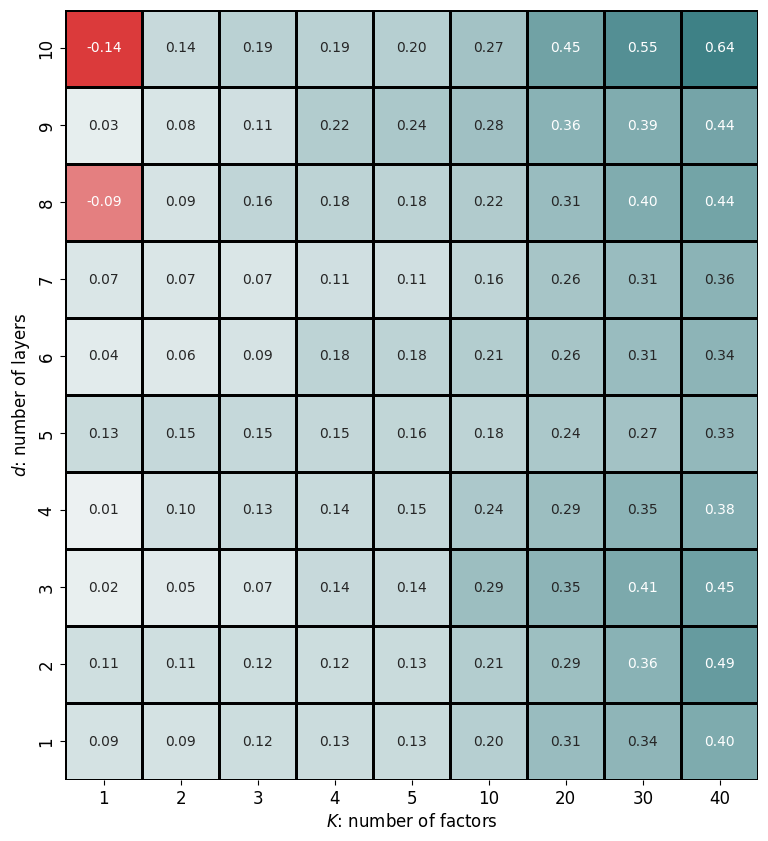

In [120]:
fontsize_=12

# Keep columns corresponding to K grid
K_grid=[0, 1, 2, 3, 4, 9, 19, 29, 39]

oos_sr_annualized = oos_sr_annualized[:, K_grid]
#oos_sr_annualized = [oos_sr_annualized[i] for i in K_grid]

# Reshape oos_sr_annualized to a 2D array
#oos_sr_annualized = np.array(oos_sr_annualized).reshape(1, -1) # Reshape to a 2D array with one row

# Determine the color map based on the minimum value in the heatmap data
min_value = np.min(oos_sr_annualized)
if min_value < 0:
    norm = TwoSlopeNorm(vmin=min_value, vcenter=0, vmax=oos_sr_annualized.max())
    cmap = sns.diverging_palette(12, 200, as_cmap=True)  # 240 for blue, 10 for red
else:
    norm = None
    cmap = sns.light_palette("darkgreen", as_cmap=True)

# Create and display the heatmap
plt.figure(figsize=(len(K_grid), 10))
heat_map = sns.heatmap(oos_sr_annualized, annot=True, fmt=".2f", cmap=cmap, norm=norm,
                        annot_kws={'fontsize': 10}, linewidths=0.85,
                        linecolor='black', cbar=False, xticklabels=[x+1 for x in K_grid], yticklabels=layer_values[::-1], square=True)

# Configure heatmap aesthetics
heat_map.tick_params(labelsize=fontsize_)
#plt.title(f'Annualized Sharpe Ratio OOS - Neighboring Characteristics: \n FF5 Asset Pricing Factors', fontsize=fontsize_)
plt.xlabel('$K$: number of factors', fontsize=fontsize_)
plt.ylabel('$d$: number of layers', fontsize=fontsize_)
